This is where the metadata, feature space, and genres are read in and stored in the "songs" dictionary by `track_id`.

In [13]:
import sklearn
import numpy as np
import pandas as pd

from sklearn.feature_extraction import DictVectorizer
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier
from random import sample as rand_sample
from random import choice as rand_choice
from sklearn.cluster import KMeans
from maps import FrozenMap, FixedKeyMap
from copy import deepcopy

In [2]:
def read_data(file):
    '''
    description

    :param file:        file we're reading in with the data (.csv)

    :return             a 'songs' dictionary
                        key: track_id
                        value(s): a 'data' dictionary, which contains:
                            metadata,
                            label,
                            features,
                            genres
    '''
    
    songs = {}

    with open(file, 'r') as f:

        for song in f:
            
            line = song.split(',')
                        
            # ignore first line + ensure that label exists
            if line[0] != 'label' and line[0]:
                label = int(line[0])
                metadata, data = {}, {}
                genres = []
                track_id = line[1]
                
                features = {}
                features['artist_popularity'] = line[4]
                features['artist_followers'] = line[5]

                metadata['artist_id'] = line[2]
                metadata['artist_name'] = line[3]
                
                # check if genre field has multiple genres or just one
                if line[6]:
                    genres.append(line[6][1:]) if '"' in line[6] else genres.append(line[6])

                count = 0
                
                # if '"' present or next value is a string only containing alphabets,
                # then add to genres list. set count to i+1 when you reach last genre
                for i in range(7, len(line)):
                    if '"' in line[i]:
                        genres.append(line[i][:-1])
                        count = i+1
                        break
                    if line[i].isalpha():
                        genres.append(line[i])
                
                # single or no genres, get all other features
                if count == 0:
                    features['instrumentalness'] = float(line[7])
                    features['duration_ms'] = float(line[8])
                    features['time_signature'] = float(line[9])
                    features['acousticness'] = float(line[10])
                    features['speechiness'] = float(line[11])
                    features['energy'] = float(line[12])
                    features['loudness'] = float(line[13])
                    features['tempo'] = float(line[14])
                    features['key'] = float(line[15])
                    features['valence'] = float(line[16])
                    features['danceability'] = float(line[17])
                    features['liveness'] = float(line[18][:-1])
                
                # multiple genres, get all other features using count
                else:
                    features['instrumentalness'] = float(line[count])
                    features['duration_ms'] = float(line[count+1])
                    features['time_signature'] = float(line[count+2])
                    features['acousticness'] = float(line[count+3])
                    features['speechiness'] = float(line[count+4])
                    features['energy'] = float(line[count+5])
                    features['loudness'] = float(line[count+6])
                    features['tempo'] = float(line[count+7])
                    features['key'] = float(line[count+8])
                    features['valence'] = float(line[count+9])
                    features['danceability'] = float(line[count+10])
                    features['liveness'] = float(line[count+11][:-1])
                
                # add metadata, features, genres, and label to data
                data['metadata'] = metadata
                data['features'] = features
                data['genres'] = genres
                data['label'] = label
                
                # add data to songs by track_id
                songs[track_id] = data

    return songs

This is where genres are read in, with each genre getting a unique `genre_id`.

In [3]:
def isFloat(string):
    '''
    description

    :param string:      the string we're testing

    :return             True if the string is a float, False otherwise
    '''
    try:
        float(string)
        return True
    except ValueError:
        return False

def read_genres(file):
    '''
    description
    
    :param file:        file we're reading in with the data (.csv)
    
    :return             a 'genres' dictionary
                        key: genre
                        value: unique genre_id
    '''
    genre_mapping = {}
    genre_id = 0
    
    with open(file, 'r') as f:

        for song in f:

            line = song.split(',')

            if line[0]:

                genres = []
                
                # check if genres field is empty or contains one/multiple genres
                if line[6]:
                    genres.append(line[6][1:]) if '"' in line[6] else genres.append(line[6])

                count = 0
                
                # account for multiple genres
                for i in range(7, len(line)):
                    if '"' in line[i]:
                        genres.append(line[i][:-1])
                        count = i+1
                        break
                    if line[i].isalpha():
                        genres.append(line[i])
                
                # for genres in the genres list, ensure that the genre is not a float, create unique genre_id
                for genre in genres:
                    if (genre not in genre_mapping) and ('"' not in genre) and (not isFloat(genre)):
                        genre_mapping[genre] = genre_id
                        genre_id += 1
        
    return genre_mapping

This is where the data is actually read in. We read in the `likes.csv` + `dislikes.csv` data, and merge them into one dictionary, `song_data`.

In [4]:
default_song_data = FrozenMap(read_data('data.csv'))
genres = FrozenMap(read_genres('data.csv'))
default_feature_names = tuple(next(iter(default_song_data.values()))['features'].keys())

In [5]:
default_feature_names

('artist_popularity',
 'artist_followers',
 'instrumentalness',
 'duration_ms',
 'time_signature',
 'acousticness',
 'speechiness',
 'energy',
 'loudness',
 'tempo',
 'key',
 'valence',
 'danceability',
 'liveness')

In [6]:
# Sanity check
l, dl = 0, 0
for x in default_song_data.values():
    if x['label'] == 1: l += 1
    else: dl += 1
print(' likes:', l, '\n', 'dislikes:', dl)

 likes: 1919 
 dislikes: 3790


In [7]:
for k in genres:
    print(genres[k], k)

0 artist_genres
1 instrumentalness
2 acousticness
3 speechiness
4 energy
5 tempo
6 key
7 valence
8 danceability
9 uk contemporary r&b
10 future garage
11 house
12 nu disco
13 christmas
14 funk
15 motown
16 soul
17 dub
18 reggae
19 roots reggae
20 hindustani classical
21 indian classical
22 bass music
23 microhouse
24 indie jazz
25 dance pop
26 pop
27 chicago house
28 tech house
29 alternative dance
30 indietronica
31 new rave
32 afro house
33 filter house
34 drum and bass
35 drumfunk
36 jungle
37 neurofunk
38 uk garage
39 world fusion
40 deep house
41 minimal tech house
42 ambient
43 drone
44 electra
45 fluxwork
46 mandible
47 downtempo
48 electronic
49 vaporwave
50 wonky
51 acid idm
52 big beat
53 breakbeat
54 deep soul house
55 hip hop
56 rap
57 underground hip hop
58 aussietronica
59 french indietronica
60 british invasion
61 merseybeat
62 rock
63 deep groove house
64 bow pop
65 focus
66 neoclassical
67 adult standards
68 folk
69 soft rock
70 tropical house
71 deep melodic euro hous

In [8]:
default_feature_names

('artist_popularity',
 'artist_followers',
 'instrumentalness',
 'duration_ms',
 'time_signature',
 'acousticness',
 'speechiness',
 'energy',
 'loudness',
 'tempo',
 'key',
 'valence',
 'danceability',
 'liveness')

In [18]:
def filter_features(data, discard):
    '''
    Filters out features from data. Does not modify passed-in object (creates a copy).
    
    :param data:        dict of data, same format as song_data
    :param discard:     feature names to discard
                        
    :return             copy of data, with filtered features
    '''
    out = dict(data)
    
    for id_ in data:
        out[id_] = deepcopy(out[id_])
        out[id_]['features'] = { k:v for k, v in out[id_]['features'].items() if k not in discard }
    
    return FrozenMap(out)

def split_data(data, p):
    '''
    Splits data into training and validation sets for simple classification.
    
    :param data:    complete labeled data
    :param p:       proportion of data to use for validation
                    
    :return         train_data, validation_data
    '''
    validation_ids = rand_sample(list(data), int(len(data) * p))
    
    validation_data = {k:data[k] for k in validation_ids}
    train_data = {k:v for k, v in data.items() if k not in validation_data}

    return FrozenMap(train_data), FrozenMap(validation_data)


In [10]:
def test_cluster_size(data, max_cluster):
    '''
    description

    :param data:        the data, obtained from read_data()
    :param max_cluster: the max number of clusters to km.inertia_ on

    :return             None (prints km_inertia for each number of clusters)
    '''
    train_data = {k:v for k, v in data.items()}
    x_train = np.array([list(x['features'].values()) for x in train_data.values()])
    
    for i in range(2, max_cluster+1):
        km = KMeans(i, init='random', max_iter=300, random_state=0, n_init=30)
        km.fit(x_train)
        print(i, km.inertia_)

test_cluster_size(default_song_data, 10)

2 3123.394736313185
3 2481.716632257166
4 2152.068476365455
5 1944.165017191881
6 1824.5853227488217
7 1711.4623613593121
8 1612.5531653294152
9 1536.3092762289932
10 1474.2539202926469


In [14]:
def get_kmeans_clusters(data, n_clusters, songs_by_cluster={}):
    '''
    Assigns songs in data to :n_clusters: unique clusters.
    
    FUTURE: Refactor feature engineering such that there data
            isn't copied wholesale. E.g., implement multiple
            kinds of features or better feature filtering.
            This will require changes to Classifier.

    :param data:        the data, obtained from read_data()
    :param n_clusters:  the number of clusters used in K-means

    :return             deep copy of data with cluster property and clusters as boolean features
                        dict, n_clusters:cluster:ids_of_songs_in_cluster
    '''
    
    data = dict(data)
    
    if n_clusters in songs_by_cluster.keys(): raise ValueError(str(n_clusters) + ' clusters already computed')
    
    songs_by_cluster[n_clusters] = { i:set() for i in range(n_clusters) }
        
    train_data, track_ids = {k:v for k, v in data.items()}, list(data)

    x_train = np.array([list(x['features'].values()) for x in train_data.values()])
    y_train = [x['label'] for x in train_data.values()]

    km = KMeans(n_clusters, init='random', max_iter=300, random_state=0, n_init=30)
    km.fit(x_train)

    cluster_map = pd.DataFrame()

    cluster_map['data'], cluster_map['cluster'] = x_train.tolist(), km.labels_
    cluster_map['label'], cluster_map['track_id'] = y_train, track_ids

    for track_id in track_ids:
        
        data[track_id] = deepcopy(data[track_id])
        
        cluster = cluster_map[cluster_map['track_id'] == track_id]['cluster'].tolist()[0]
        
        songs_by_cluster[n_clusters][cluster].add(track_id)
        
        data[track_id]['cluster'] = cluster
        for i in range(n_clusters):
            data[track_id]['features']['c'+str(i)] = 1 if cluster == i else 0
    
    return FrozenMap(data), FrozenMap(songs_by_cluster)

In [15]:
NUM_CLUSTERS = 10

clustered_song_data, songs_by_cluster = get_kmeans_clusters(default_song_data, NUM_CLUSTERS)
# clustered_song_data
# songs_by_cluster

In [17]:
if set(next(iter(default_song_data.values()))['features'].keys()) == set(next(iter(clustered_song_data.values()))['features'].keys()):
    raise ValueError('Default features messed up.')

In [56]:
SUPPORTED_ALGS = ['svc', 'lsvc', 'sgd']
ONLINE_ALGS = ['sgd']
AL_STRATS = ['random', 'uncertainty']
CLASSES = [0, 1]

def get_xy(song_data, ids=None):
    if ids: song_data = {k:song_data[k] for k in ids}
    return [x['features'] for x in song_data.values()], [x['label'] for x in song_data.values()]

def get_default_vectorizer(song_data_x):
    vect = DictVectorizer(sort=True)
    return vect.fit(song_data_x)

def get_default_learner(algorithm):
    if algorithm == 'svc':
            return SVC(gamma='auto') # defaults
        
    elif algorithm == 'lsvc':
        return LinearSVC(loss='hinge', penalty='l2') # defaults

    elif algorithm == 'sgd':
        return SGDClassifier(loss='hinge', penalty='l2') # defaults
    
    else: raise ValueError('unknown algorithm: ' + str(alg))
    

In [27]:
default_song_data_x, default_song_data_y = get_xy(default_song_data)
default_vectorizer = get_default_vectorizer(default_song_data_x)

clustered_song_data_x, clustered_song_data_y = get_xy(clustered_song_data)
clustered_vectorizer = get_default_vectorizer(clustered_song_data_x)

In [82]:
class Classifier(object):
    def __init__(
        self,
        algorithm,
        train_data,
        vectorizer,
        is_active,
        active_init_n=None,
        al_strat=None,
        clusters=None
    ):
        '''
        Class providing an interface for learning experiments.
        
        :param algorithm:       the name of the learning algorithm to use
        :param train_data:      dict
        :param vectorizer:      DictVectorizer, fit on train_data features
        :param is_active:       bool
        :param active_init_n:   number of instances to initialize active learner with
        :param al_strat:        str, the active learning strategy to use
                            
        :return                 Classifier instance
        '''
        
        if algorithm not in SUPPORTED_ALGS:
            raise ValueError('Unsupported algorithm: ' + str(algorithm))
        if is_active:
            if al_strat not in AL_STRATS:
                raise ValueError('Unsupported AL strategy: ' + str(al_strat))
            if not active_init_n or active_init_n <= 0:
                raise ValueError('Invalid active_init_n: ' + str(active_init_n))
        if clusters and algorithm not in ONLINE_ALGS:
            raise ValueError('Algorithm must be online if using cluster sampling.')
        
        self.algorithm = algorithm
        self.train_data = train_data
        self.vectorizer = vectorizer
        self._is_active = is_active
        self._is_online = algorithm in ONLINE_ALGS
        self.strategy = al_strat
        self.active_init_n = active_init_n
        self.learner = get_default_learner(self.algorithm)
        
        self.clusters = clusters
        self._uses_cluster_sampling = bool(clusters)
        self.num_clusters = len(clusters) if clusters else None
        
        if not self.is_active():
            self.x_train, self.y_train = get_xy(self.train_data)
        
        else:
            if not self.uses_cluster_sampling():
                self.unseen_ids = list(self.train_data.keys())
            else:
                self.unseen_ids = { i:list(self.clusters[i]) for i in range(self.num_clusters) }
            
            self.train_ids = set()
            
            self.active_learn(n=self.active_init_n, init=True)
    
    
    def is_active(self):
        return self._is_active
    
    
    def is_online(self):
        return self._is_online
    
    
    def uses_cluster_sampling(self):
        return self._uses_cluster_sampling
    
    
    def transform(self, x):
        '''
        Vectorizes list of feature(s)
        '''
        return self.vectorizer.transform(x)
    
    
    def fit(self):
        '''
        '''
        if not self.is_active():
            self.learner.fit(self.vectorizer.transform(self.x_train), self.y_train)
        else:
            self.active_learn()
    
    
    def active_learn(self, n=1, init=False):
        
        if not self.uses_cluster_sampling():
            sample_ids = self.al_sample(n, init)
        else:
            sample_ids = self.al_sample_clusters(n, init)
        
        if not self.is_online():
            sample_x, sample_y = get_xy(self.train_data, ids=self.train_ids)
            self.learner = get_default_learner(self.algorithm)
            self.learner.fit(self.transform(sample_x), sample_y)
        else:
            sample_x, sample_y = get_xy(self.train_data, ids=sample_ids)
            if init: self.learner.partial_fit(self.transform(sample_x), sample_y, CLASSES)
            else: self.learner.partial_fit(self.transform(sample_x), sample_y)
        
    def al_sample(self, n, init):
        
        strategy = self.strategy if not init else 'random'
        
        if strategy == 'random':
            
            # Initial samples must contain all labels for offline learners.
            # This ensures that happens.
            if init and not self.is_online():
                sampled_classes = set()
                while len(sampled_classes) != len(CLASSES):
                    sampled_classes = set()
                    sample_ids = rand_sample(self.unseen_ids, n)
                    sampled_classes = set()
                    for id_ in sample_ids:
                        sampled_classes.add(self.train_data[id_]['label'])
            else:
                sample_ids = rand_sample(self.unseen_ids, n)
                
            for song_id in sample_ids: self.unseen_ids.remove(song_id)
        
        elif strategy == 'uncertainty':
            unseen_x, unseen_y = get_xy(self.train_data, ids=self.unseen_ids)
            unseen_x_scores = self.learner.decision_function(self.transform(unseen_x))
            
            # get index of smallest absolute value (probability or distance from decision boundary)
            # from unseen_x_scores, pop the corresponding entry from self.unseen_ids
            sample_ids = [self.unseen_ids.pop(np.argmin(np.abs(unseen_x_scores)))]
        
        self.train_ids.update(sample_ids)
        
        return sample_ids
    
    
    def al_sample_clusters(self, n, init):
        
        strategy = self.strategy if not init else 'random'
        
        sample_ids = []
        
        for i in range(self.num_clusters):
            
            if strategy == 'random':
                new_sample_ids = rand_sample(self.unseen_ids[i], n)
                for song_id in new_sample_ids: self.unseen_ids[i].remove(song_id)
                sample_ids += new_sample_ids

            elif strategy == 'uncertainty':
                unseen_x, unseen_y = get_xy(self.train_data, ids=self.unseen_ids[i])
                unseen_x_scores = self.learner.decision_function(self.transform(unseen_x))

                # get index of smallest absolute value (probability or distance from decision boundary)
                # from unseen_x_scores, pop the corresponding entry from self.unseen_ids
                sample_ids.append(self.unseen_ids[i].pop(np.argmin(np.abs(unseen_x_scores))))
            
        self.train_ids.update(sample_ids)
        
        return sample_ids
    
    
    def predict(self, x, learner=None):
        return self.learner.predict(x)[0]
    
    
    def validate(self, validation_data):
        '''
        Predicts on all instances in validation_data. Returns accuracy.
        '''
        x_test, y_test = get_xy(validation_data)
        
        correct = 0
        for i in range(len(validation_data)):
            if self.predict(self.transform([x_test[i]])) == y_test[i]: correct += 1
        
        return correct / len(validation_data)


In [83]:
def get_experiment_split(p=0.2):
    # if discard: data = filter_features(data, discard)

    default_trd, default_vd = split_data(default_song_data, p)
    return default_trd, default_vd, { k:clustered_song_data[k] for k in default_trd }, { k:clustered_song_data[k] for k in default_vd }

def get_train_clusters(clustered_train_data, all_clusters):
    return { c:[_id for _id in all_clusters[c] if _id in clustered_train_data] for c in all_clusters}

def run_active_experiment(train_data, validation_data, iterations, alg, init_n, strat='random', clusters=None):
    '''
    Trains :alg: on song_data (with or without filtering features), splits into train/validation,
    and returns accuracy on validation data.
    '''
    
    clf = Classifier(
        alg,
        train_data,
        default_vectorizer,
        True,
        active_init_n=init_n,
        al_strat=strat,
        clusters=clusters
    )
    accuracies = [clf.validate(validation_data)]
    
    for i in range(iterations):
        clf.active_learn()
        accuracies.append(clf.validate(validation_data))
    
    return accuracies

def run_active_suite(train_data, validation_data):
    
    results = {}
    
    for alg in SUPPORTED_ALGS:
        
        results[alg] = {}
        
        for strat in AL_STRATS:
            init_n = 5
            accs = run_active_experiment(train_data, validation_data, 50, alg, init_n, strat=strat)
            print(alg, 'accs w/', strat)
            for i in range(len(accs)):
                print(int(accs[i]*10000)/100, end='\t')
            print()
            
            results[alg][strat] = accs
            
    return results

def run_clusters_suite(train_data, validation_data, train_clusters):
    
    results = {}
    
    for alg in ONLINE_ALGS:
        
        results[alg] = {}
        
        for strat in AL_STRATS:
            
            accs = run_active_experiment(
                train_data, validation_data, 50//NUM_CLUSTERS, alg, len(train_clusters),
                strat=strat, clusters=train_clusters
            )
            print(alg, 'accs w/', strat)
            for i in range(len(accs)):
                print(int(accs[i]*10000)/100, end='\t')
            print()
            
            results[alg][strat] = accs
    
    return results

In [84]:
default_training_data, default_validation_data, clustered_training_data, clustered_validation_data = get_experiment_split()
training_clusters = get_train_clusters(clustered_training_data, songs_by_cluster[NUM_CLUSTERS])
print('----\nUnclustered\n----')
active_unclustered_results = run_active_suite(default_training_data, default_validation_data)
print('----\nClustered\n----')
active_clustered_results = run_active_suite(clustered_training_data, clustered_validation_data)
print('\n----\nClustered w/ Cluster Sampling\n----')
active_cluster_sampled_results = run_clusters_suite(clustered_training_data, clustered_validation_data, training_clusters)

----
Unclustered
----
svc accs w/ random
66.87	66.87	66.87	66.87	66.87	66.87	66.87	66.87	66.87	66.87	66.87	66.87	66.87	66.87	66.87	66.87	66.87	66.87	66.87	66.87	66.87	66.87	66.87	66.87	66.87	66.87	66.87	66.87	66.87	66.87	66.87	66.87	66.87	66.87	66.87	66.87	66.87	66.87	66.87	66.87	66.87	66.87	66.87	66.87	66.87	66.87	66.87	66.87	66.87	66.87	66.87	
svc accs w/ uncertainty
66.87	66.87	66.87	67.92	33.12	69.93	33.12	75.54	33.12	80.1	33.12	82.99	66.87	81.68	33.12	84.92	33.12	85.53	66.87	85.45	33.12	86.32	33.12	87.02	33.12	85.36	66.87	86.76	33.12	85.8	66.87	86.67	33.12	86.67	66.87	86.67	33.12	86.85	33.12	85.71	33.12	84.13	66.87	86.5	33.12	85.88	33.12	84.13	33.12	82.29	66.87	
lsvc accs w/ random
66.95	65.81	65.73	65.81	66.34	66.34	66.34	66.52	66.52	66.52	67.92	67.92	67.83	67.48	73.53	73.53	73.0	78.61	78.61	78.35	78.35	78.35	79.49	80.63	80.63	83.61	85.53	85.71	85.45	85.45	85.88	86.15	86.32	86.59	86.59	86.5	86.59	86.24	86.24	86.24	86.41	86.5	86.06	86.06	86.06	86.06	86.06	85.71	85.71	85.97	86.15	


In [88]:
def run_benchmark(alg, data, p, discard=None):
    '''
    Trains :alg: on song_data (with or without filtering features), splits into train/validation,
    and returns accuracy on validation data.
    '''
    if discard: data = filter_features(data, discard)
    
    train_data, validation_data = split_data(data, p)
    
    clf = Classifier(alg, train_data, default_vectorizer, False)
    clf.fit()
    
    return clf, train_data, validation_data

In [89]:
test_clf, test_td, test_vd = run_benchmark('svc', default_song_data, 0.2)
svc_bench_acc = test_clf.validate(test_vd)
print('svc acc:', svc_bench_acc)
test_clf, test_td, test_vd = run_benchmark('lsvc', default_song_data, 0.2)
lsvc_bench_acc = test_clf.validate(test_vd)
print('lsvc acc:', lsvc_bench_acc)
test_clf, test_td, test_vd = run_benchmark('sgd', default_song_data, 0.2)
sgd_bench_acc = test_clf.validate(test_vd)
print('sgd acc:', sgd_bench_acc)
# print()
# print(active_unclustered_results)
# print(active_clustered_results)
# print(active_cluster_sampled_results)

svc acc: 0.6827344434706398
lsvc acc: 0.9149868536371604
sgd acc: 0.9149868536371604

{'svc': {'random': [0.6687116564417178, 0.6687116564417178, 0.6687116564417178, 0.6687116564417178, 0.6687116564417178, 0.6687116564417178, 0.6687116564417178, 0.6687116564417178, 0.6687116564417178, 0.6687116564417178, 0.6687116564417178, 0.6687116564417178, 0.6687116564417178, 0.6687116564417178, 0.6687116564417178, 0.6687116564417178, 0.6687116564417178, 0.6687116564417178, 0.6687116564417178, 0.6687116564417178, 0.6687116564417178, 0.6687116564417178, 0.6687116564417178, 0.6687116564417178, 0.6687116564417178, 0.6687116564417178, 0.6687116564417178, 0.6687116564417178, 0.6687116564417178, 0.6687116564417178, 0.6687116564417178, 0.6687116564417178, 0.6687116564417178, 0.6687116564417178, 0.6687116564417178, 0.6687116564417178, 0.6687116564417178, 0.6687116564417178, 0.6687116564417178, 0.6687116564417178, 0.6687116564417178, 0.6687116564417178, 0.6687116564417178, 0.6687116564417178, 0.668711656441

In [95]:
print(active_unclustered_results.keys())
print(active_clustered_results.keys())
print(active_cluster_sampled_results.keys())

dict_keys(['svc', 'lsvc', 'sgd'])
dict_keys(['svc', 'lsvc', 'sgd'])
dict_keys(['sgd'])


In [96]:
result_list = [active_unclustered_results, active_clustered_results]
label_list = ['Unclustered', 'Clustered']

def get_new_results(alg):
    new_results = {}
    for i in range(len(result_list)):
        new_results[label_list[i]] = {}
        for k in result_list[i][alg]: new_results[label_list[i]][k] = result_list[i][alg][k]
    return new_results

svc_results = get_new_results('svc')
lsvc_results = get_new_results('lsvc')
sgd_results = get_new_results('sgd')

In [120]:
def get_plottable_results(data):
    y, labels = [], []
    #print(svc_results.keys())
    for k in data:
        #print(svc_results[k].keys())
        for l in data[k]:
            #print(type(svc_results[k][l]))
            y.append(data[k][l])
            labels.append(k + ' ' + (' Random' if l == 'random' else ' Uncertainty'))
    return y, labels

svc_y, svc_l = get_plottable_results(svc_results)
lsvc_y, lsvc_l = get_plottable_results(lsvc_results)
sgd_y, sgd_l = get_plottable_results(sgd_results)

svc_y_r, svc_l_r = svc_y[::2], svc_l[::2]
svc_y_u, svc_l_u = svc_y[1::2], svc_l[1::2]
# lsvc_y_r, lsvc_l_r = lsvc_y[::2], lsvc_l[::2]
# lsvc_y_u, lsvc_l_u = lsvc_y[1::2], lsvc_l[1::2]
sgd_y_r, sgd_l_r = sgd_y[::2], sgd_l[::2]
sgd_y_u, sgd_l_u = sgd_y[1::2], sgd_l[1::2]

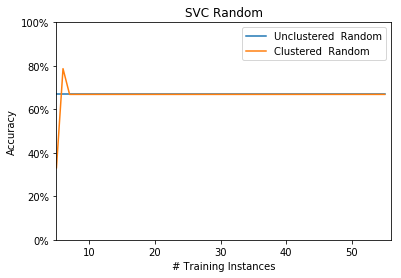

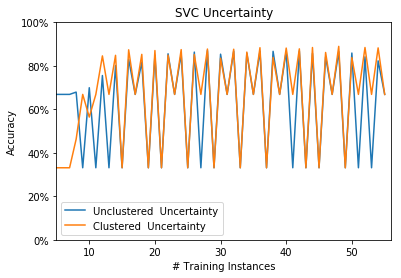

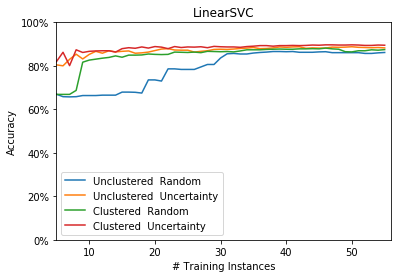

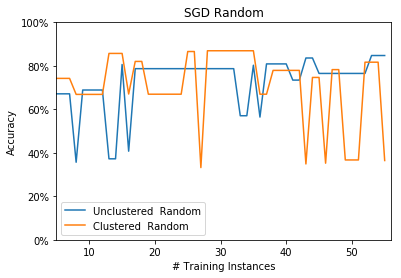

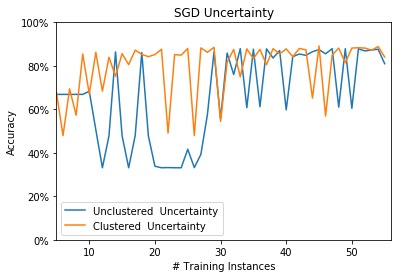

In [121]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

def accuracy_plot(y, labels, title):
    
    x = [i + 5 for i in range(len(y[0]))]
 
    for i in range(len(y)):
        plt.plot(x, y[i], '-', label=labels[i])
    plt.legend()
    plt.title(title)
    plt.xlabel('# Training Instances')
    plt.ylabel('Accuracy')
    plt.axis([5, 5+len(y[0]), 0, 1.0])
    plt.axes().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    plt.show()

accuracy_plot(svc_y_r, svc_l_r, 'SVC Random')
accuracy_plot(svc_y_u, svc_l_u, 'SVC Uncertainty')
accuracy_plot(lsvc_y, lsvc_l, 'LinearSVC')
accuracy_plot(sgd_y_r, sgd_l_r, 'SGD Random')
accuracy_plot(sgd_y_u, sgd_l_u, 'SGD Uncertainty')

# def get_accuracy_plots():
#     for alg in SUPPORTED_ALGS:
#         accuracy_plot(basic_results[i][:2], basic_titles[i])
        
# get_accuracy_plots()


In [ ]:
# def get_adv_plots():
#     for i in range(len(adv_results)):
#         accuracy_plot(adv_results[i][:2], adv_titles[i])
#         loss_plot(adv_results[i][2], adv_titles[i])

# # basic_results = [e1_results, e2_results, e3_results]
# # basic_titles = ['Experiment 1: Baseline FFNN', 'Experiment 2: Baseline CNN', 'Experiment 3: CNN w/ Normalized Images']
# adv_results = [ffn_results, cnn_results]
# adv_titles = ['Experiment 4: Hyperparameterized FFNN', 'Experiment 4: Hyperparameterized CNN']

# # for i in range(3):
# #     for j in range(3):
# #         print(basic_results[i][j][-1])
# #     print()
